In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data

from datasets.em_stack import EMStackDataset, load_dataset
from models.unet import UNet
from utils import display_predictions, display_segmentation, train

In [4]:
data_directory = "/share/nikola/export/dt372/isbi"
train_volume, train_labels, test_volume = load_dataset(data_directory)

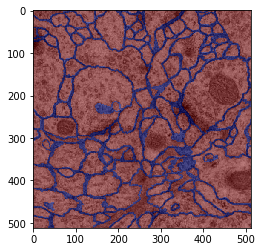

In [5]:
display_segmentation(train_volume[..., 0], train_labels[..., 0])

In [6]:
tr_ds, te_ds = EMStackDataset(train_volume, train_labels), \
               EMStackDataset(test_volume, test_volume)

In [7]:
tr_dl, te_dl = data.DataLoader(tr_ds), data.DataLoader(te_ds)

In [8]:
transposed_model = UNet(3, 2, dilated=False)
if torch.cuda.is_available():
    transposed_model = transposed_model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transposed_model.parameters(), lr=1e-2, betas=(0.99, 0.999))
transposed_losses = []

Learning rate changed to: 0.01000


/home/dt372/anaconda2/envs/unet/lib/python3.7/site-packages/torchvision/transforms/functional.py:440: UserWarning: torch.gels is deprecated in favour of torch.lstsq and will be removed in the next release. Please use torch.lstsq instead.
  res = torch.gels(B, A)[0]


Learning rate changed to: 0.00970
Learning rate changed to: 0.00941
Learning rate changed to: 0.00913
Learning rate changed to: 0.00885
Learning rate changed to: 0.00859
Learning rate changed to: 0.00833
Learning rate changed to: 0.00808
Learning rate changed to: 0.00784
Learning rate changed to: 0.00760
Learning rate changed to: 0.00737
Learning rate changed to: 0.00715
Learning rate changed to: 0.00694
Learning rate changed to: 0.00673
Learning rate changed to: 0.00653
Learning rate changed to: 0.00633
Learning rate changed to: 0.00614
Learning rate changed to: 0.00596
Learning rate changed to: 0.00578
Learning rate changed to: 0.00561
Learning rate changed to: 0.00544
Learning rate changed to: 0.00527
Learning rate changed to: 0.00512
Learning rate changed to: 0.00496
Learning rate changed to: 0.00481
Learning rate changed to: 0.00467
Learning rate changed to: 0.00453
Learning rate changed to: 0.00439
Learning rate changed to: 0.00426
Learning rate changed to: 0.00413
Learning rate 

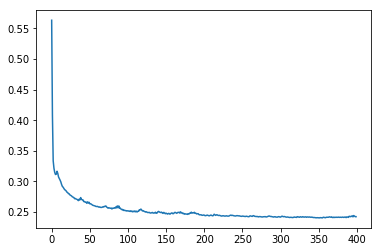

In [9]:
transposed_losses.extend(train(transposed_model, tr_dl, criterion, optimizer, 400))
plt.plot(list(range(transposed_model.epoch)), transposed_losses)

In [10]:
dilation_model = UNet(3, 2)
if torch.cuda.is_available():
    dilation_model = dilation_model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dilation_model.parameters(), lr=1e-2, betas=(0.99, 0.999))
dilated_losses = []

Learning rate changed to: 0.01000
Learning rate changed to: 0.00970
Learning rate changed to: 0.00941
Learning rate changed to: 0.00913
Learning rate changed to: 0.00885
Learning rate changed to: 0.00859
Learning rate changed to: 0.00833
Learning rate changed to: 0.00808
Learning rate changed to: 0.00784
Learning rate changed to: 0.00760
Learning rate changed to: 0.00737
Learning rate changed to: 0.00715
Learning rate changed to: 0.00694
Learning rate changed to: 0.00673
Learning rate changed to: 0.00653
Learning rate changed to: 0.00633
Learning rate changed to: 0.00614
Learning rate changed to: 0.00596
Learning rate changed to: 0.00578
Learning rate changed to: 0.00561
Learning rate changed to: 0.00544
Learning rate changed to: 0.00527
Learning rate changed to: 0.00512
Learning rate changed to: 0.00496
Learning rate changed to: 0.00481
Learning rate changed to: 0.00467
Learning rate changed to: 0.00453
Learning rate changed to: 0.00439
Learning rate changed to: 0.00426
Learning rate 

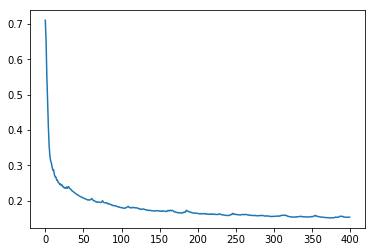

In [11]:
dilated_losses.extend(train(dilation_model, tr_dl, criterion, optimizer, 400))
plt.plot(list(range(dilation_model.epoch)), dilated_losses)

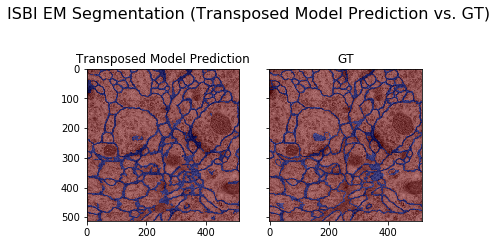

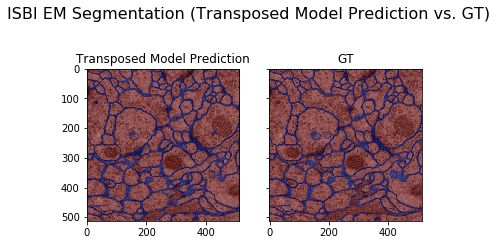

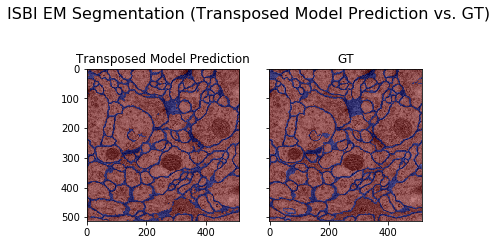

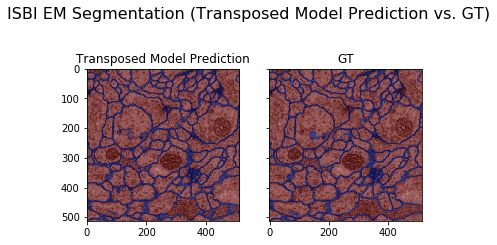

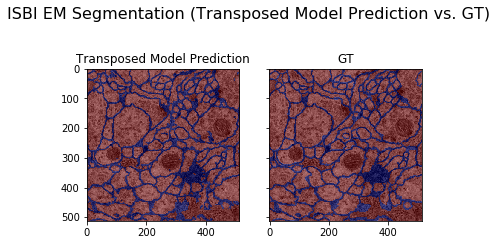

In [12]:
display_predictions(transposed_model, tr_dl, model_name="Transposed Model")

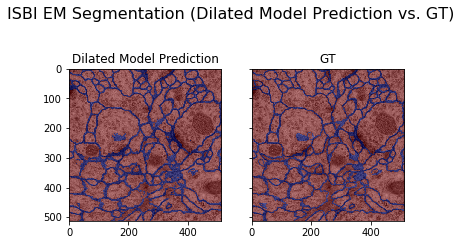

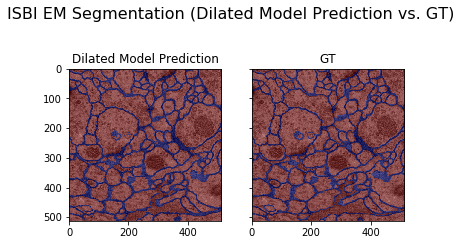

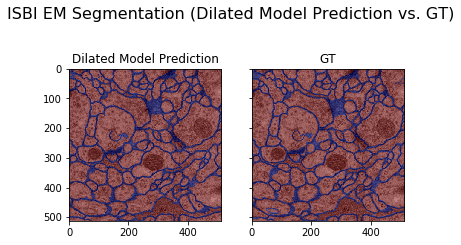

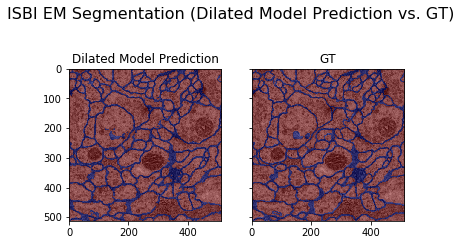

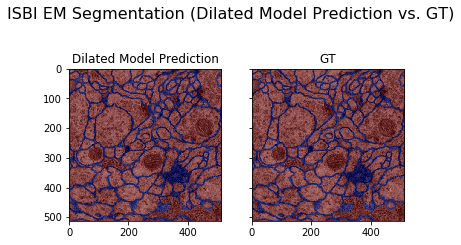

In [13]:
display_predictions(dilation_model, tr_dl, model_name="Dilated Model")